In [1]:
import numpy as np
import pandas as pd
import implicit
import random 
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import time

In [2]:
website_url = '../Dataset/Online Retail.xlsx'
retail_data = pd.read_excel(website_url)

In [3]:
cleaned_retail = retail_data.loc[pd.isnull(retail_data.CustomerID) == False]

In [4]:
cleaned_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
class Recommendation:
    def __init__(self, input_dataframe, feature_columns={"item_column":None, 
                                                         "user_column": None, 
                                                         "score_column":None,
                                                         "item_description_column":None}, isPreprocess=False, isSum=True):
        self.feature_columns = feature_columns
        self.df_columns = list(self.feature_columns.values())
        self.input_dataframe = input_dataframe[self.df_columns]
        self.isPreprocess = isPreprocess
        self.isSum=isSum
        if self.isPreprocess:
            self.preprocess(isSum=isSum)
        if len(self.feature_columns) == 4:
            self.item_lookup = self.input_dataframe[[self.feature_columns["item_column"], self.feature_columns["item_description_column"]]].drop_duplicates()
    
    def preprocess(self, isSum=True):
        if isSum:
            cleaned_df = self.input_dataframe.groupby([self.feature_columns['user_column'], 
                                                   self.feature_columns['item_column']]).sum().reset_index()
        else:
            cleaned_df = self.input_dataframe.groupby([self.feature_columns['user_column'], 
                                                   self.feature_columns['item_column']]).mean().reset_index()
            
        cleaned_df[self.feature_columns['score_column']].loc[cleaned_df[self.feature_columns['score_column']] == 0] = 1
        grouped_purchased = cleaned_df.query(self.feature_columns['score_column']+' > 0')
        
        # Creating the sparse matrix

        self.user = list(np.sort(grouped_purchased[self.feature_columns['user_column']].unique())) # Get our unique customers
        self.item = list(grouped_purchased[self.feature_columns['item_column']].unique()) # Get our unique products that were purchased
        self.score = list(grouped_purchased[self.feature_columns['score_column']]) # All of our purchases


        # Get the associated row & column indices
        self.row_indices = grouped_purchased[self.feature_columns['user_column']].astype('category', categories = self.user).cat.codes 
        self.col_indices = grouped_purchased[self.feature_columns['item_column']].astype('category', categories = self.item).cat.codes 

        self.sparse_matrix = sparse.csr_matrix((self.score, (self.row_indices, self.col_indices)), shape=(len(self.user), len(self.item)))
        self.isPreprocess=True
    
    def describe_sparse_matrix(self, isSum=True, verbose=1):
        if self.isPreprocess == False:
            self.preprocess(isSum=isSum)
        self.matrix_size = self.sparse_matrix.shape[0]*self.sparse_matrix.shape[1] 
        num_purchases = len(self.sparse_matrix.nonzero()[0]) 
        self.sparsity = 100*(1 - (num_purchases/self.matrix_size))
        if verbose==1:
            print("Maximum possible sparsity for collaborative filtering approach is 99.5%.")
            print()
            if self.sparsity < 99.5:
                print("Sparsity is ~"+str(round(self.sparsity,2))+", we can expect decent results.")
            else:
                print("Sparsity is "+str(round(self.sparsity,2)) + "%, Try to reduce as per the standard")
    
    def create_split_data(self, score, pct_test = 0.2):
        
        self.test_set = score.copy() 
        self.test_set[self.test_set != 0] = 1 

        self.training_set = score.copy() 

        nonzero_inds = self.training_set.nonzero() 
        nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 

        random.seed(0) 

        num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) 
        samples = random.sample(nonzero_pairs, num_samples) 

        self.user_inds = [index[0] for index in samples] 
        self.item_inds = [index[1] for index in samples] 

        self.training_set[self.user_inds, self.item_inds] = 0 
        self.training_set.eliminate_zeros() 

        return self.training_set, self.test_set, self.user_inds
    
    def train(self, factors, alpha, regularization=0.1, iterations=50, num_threads=1, isEvaluate=False, Verbose=0):
        show_progress=False
        self.describe_sparse_matrix(isSum=self.isSum, verbose=Verbose)
        train_set, _, _ = self.create_split_data(self.sparse_matrix)
        self.als = implicit.als.AlternatingLeastSquares(factors=factors, 
                                     regularization = regularization, 
                                     iterations = iterations,
                                    num_threads=num_threads)
        if Verbose==1:
            show_progress=True
        self.als.fit(train_set.transpose() * alpha, show_progress=show_progress)
        if Verbose==1:
            print("Training completed...")
        if isEvaluate:
            _f1_score, _roc_auc_score = self.get_f1_score_v2()
            if Verbose==1:
                print(" F1 Score: ",_f1_score, " AUC ROC score: ", _roc_auc_score)
            return _f1_score, _roc_auc_score
    
    def get_recommendation(self, user_id, is_lookup_items=False, N=10):
        lookup_flag = False
        if is_lookup_items :
            if len(self.feature_columns) == 4:
                lookup_flag=True
            else:
                print("Instantiate object with four columns. See the docs for item lookups.")
            
        idx = np.where(np.array(self.user)==int(user_id))[0][0]
        recommendations = self.als.recommend(idx, self.training_set, N)
        recommendations_list = []
        score_list = []
        item_lookup_list = []
        for name_id, score in recommendations:
            recommendations_list.append(self.item[name_id])
            score_list.append(score)
            if lookup_flag:
                item_lookup_list.append(self.item_lookup[self.feature_columns["item_description_column"]].loc[self.item[name_id] == self.item_lookup[self.feature_columns["item_column"]]].iloc[0])
        return recommendations_list, score_list, item_lookup_list
    
    def get_similar_items(self, item_id, is_lookup_items=False, N=10):
        lookup_flag = False
        if is_lookup_items :
            if len(self.feature_columns) == 4:
                lookup_flag=True
            else:
                print("Instantiate object with four columns. See the docs for item lookups.")
        idx = np.where(np.array(self.item)==str(item_id))[0][0]
        items = self.als.similar_items(idx, N)
        item_list = []
        score_list = []
        item_lookup_list = []
        for name_id, score in items:
            item_list.append(self.item[name_id])
            score_list.append(score)
            if lookup_flag:
                item_lookup_list.append(self.item_lookup[self.feature_columns["item_description_column"]].loc[self.item[name_id] == self.item_lookup[self.feature_columns["item_column"]]].iloc[0])
        return item_list, score_list, item_lookup_list
    
    def calc_f1_score(self, predictions, test):
        score = f1_score(test, predictions, average="weighted")
        return score
    
    def get_f1_score(self):
        f1_score_list = []
        roc_auc_score_list =[]
        for user in tqdm(self.user_inds):
            train_rows = self.training_set[user].toarray().reshape(-1)
            zero_idxs = np.where(train_rows == 0)

            #get prediction based on user/item sparse matrix
            user_vec = self.als.user_factors[user,:]
            pred = user_vec.dot(self.als.item_factors.T)[zero_idxs]
            pred_bin = np.ones(shape=pred.shape)
            pred_bin[np.where(pred<0.5)] = 0

            true_pred = self.test_set[user, :].toarray()[0,zero_idxs].reshape(-1)
            f1_score_list.append(f1_score(true_pred, pred_bin))
            roc_auc_score_list.append(roc_auc_score(true_pred, pred_bin))
        return np.mean(f1_score_list), np.mean(roc_auc_score_list)
    
    def get_f1_score_v2(self):
        zro_idx = np.where(rec.training_set[rec.user_inds].toarray() == 0)

        pred = rec.als.user_factors[rec.user_inds].dot(rec.als.item_factors.T)[zro_idx]
        pred_bin = np.ones(shape=pred.shape)
        pred_bin[np.where(pred<0.5)] = 0

        test_pred = rec.test_set[rec.user_inds].toarray()[zro_idx]

        return f1_score(test_pred, pred_bin), roc_auc_score(pred_bin, test_pred)
        
    def grid_search(self, factors_list, alpha_list, regularisation_list, iter_list, isDisplayChart=True):
        start_time = time.time()
        self.combination_dict = {
                "factors" : factors_list,
                "alpha" : alpha_list,
                "regularisation" : regularisation_list,
                "iterations" : iter_list,
            }
        self.describe_sparse_matrix(isSum=self.isSum)
        all_combinations = list(itertools.product(*list(self.combination_dict.values())))
        score_list=[]
        for idx, values in enumerate(all_combinations):
            start_epoch_time=time.time()
            _f1_score, _roc_auc_score=self.train( factors=values[0], 
                                                   alpha=values[1], 
                                                   regularization=values[2], 
                                                   iterations=values[3], 
                                                   num_threads=1, 
                                                   isEvaluate=True, 
                                                   Verbose=0)
            end_epoch_time=time.time()
            print("Steps: ",idx+1,"/",len(all_combinations)," | Combination: ", values, " | Execution time: ", self.calculate_execution_time(end_epoch_time - start_epoch_time))
            print("F1 Score: ", _f1_score, " AUC Score: ", _roc_auc_score)
            print()
            score_list.append(_f1_score)
            
        if isDisplayChart:
            plt.figure(figsize=(15, 7))
            sns.barplot(["comb_"+str(v) for v in range(len(score_list))], score_list)
            plt.title("Grid Search ")
            plt.xlabel("Combinations")
            _=plt.ylabel("F1 Score")
        result = all_combinations[score_list.index(max(score_list))]
        best_combinations_dict={
                "factors" : result[0],
                "alpha" : result[1],
                "regularisation" : result[2],
                "iterations" : result[3],
            }
        end_time = time.time()
        print("Execution time: ",self.calculate_execution_time(end_time-start_time))
        return best_combinations_dict
    
    def calculate_execution_time(self, seconds): 
        seconds = seconds % (24 * 3600) 
        hour = seconds // 3600
        seconds %= 3600
        minutes = seconds // 60
        seconds %= 60

        return "%d:%02d:%02d" % (hour, minutes, seconds)


In [6]:
feature_columns = {"item_column":"StockCode", 
                   "user_column": "CustomerID", 
                   "score_column":"Quantity",
                   "item_description_column":"Description"}
rec = Recommendation(cleaned_retail, feature_columns=feature_columns, isPreprocess=False)

In [7]:
rec.train(factors=240, alpha=15, iterations=400, Verbose=1, isEvaluate=True)

/home/dhruv.s/.local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/dhruv.s/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/dhruv.s/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Maximum possible sparsity for collaborative filtering approach is 99.5%.

Sparsity is ~98.32, we can expect decent results.



Training completed...
 F1 Score:  0.18877596430165586  AUC ROC score:  0.5667569166639088


(0.18877596430165586, 0.5667569166639088)

Maximum possible sparsity for collaborative filtering approach is 99.5%.

Sparsity is ~98.32, we can expect decent results.
Steps:  1 / 96  | Combination:  (40, 15, 0.1, 200)  | Execution time:  0:04:21
F1 Score:  0.0874307901650067  AUC Score:  0.5219459374131254

Steps:  2 / 96  | Combination:  (40, 15, 0.1, 400)  | Execution time:  0:05:44
F1 Score:  0.08770583360200558  AUC Score:  0.5220085821444161

Steps:  3 / 96  | Combination:  (40, 15, 0.2, 200)  | Execution time:  0:04:29
F1 Score:  0.08762151088305231  AUC Score:  0.5219952131165307

Steps:  4 / 96  | Combination:  (40, 15, 0.2, 400)  | Execution time:  0:05:39
F1 Score:  0.08792197380803328  AUC Score:  0.5220744449244732

Steps:  5 / 96  | Combination:  (40, 15, 0.4, 200)  | Execution time:  0:04:26
F1 Score:  0.08807388746351998  AUC Score:  0.5221237111390032

Steps:  6 / 96  | Combination:  (40, 15, 0.4, 400)  | Execution time:  0:05:32
F1 Score:  0.08832701544704495  AUC Score:  0.5221975427669825

Steps:  7 / 96  | C

Steps:  57 / 96  | Combination:  (250, 35, 0.2, 200)  | Execution time:  0:06:38
F1 Score:  0.19042871498925887  AUC Score:  0.5624594358883784

Steps:  58 / 96  | Combination:  (250, 35, 0.2, 400)  | Execution time:  0:10:07
F1 Score:  0.18890916146638542  AUC Score:  0.5644924639999935

Steps:  59 / 96  | Combination:  (250, 35, 0.4, 200)  | Execution time:  0:06:43
F1 Score:  0.19340868685825402  AUC Score:  0.5632118303800061

Steps:  60 / 96  | Combination:  (250, 35, 0.4, 400)  | Execution time:  0:10:09
F1 Score:  0.18987610822608506  AUC Score:  0.564751241812949

Steps:  61 / 96  | Combination:  (250, 70, 0.1, 200)  | Execution time:  0:06:44
F1 Score:  0.19460805840853979  AUC Score:  0.5595576803814878

Steps:  62 / 96  | Combination:  (250, 70, 0.1, 400)  | Execution time:  0:10:05
F1 Score:  0.19087444350443117  AUC Score:  0.562104203642926

Steps:  63 / 96  | Combination:  (250, 70, 0.2, 200)  | Execution time:  0:06:40
F1 Score:  0.19285850779718686  AUC Score:  0.55931

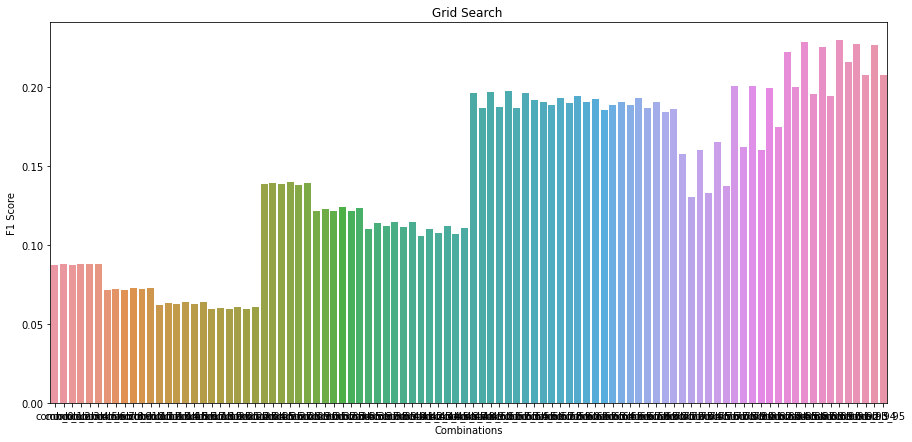

In [8]:
#V2
result =rec.grid_search(factors_list= [40, 100, 250, 400], 
                alpha_list=[15, 35, 70, 95], 
                regularisation_list=[ 0.1, 0.2, 0.4], 
                iter_list=[200, 400])

In [9]:
result

{'factors': 400, 'alpha': 95, 'regularisation': 0.1, 'iterations': 200}

In [16]:
time.time()-1596087621.249582

422.6803722381592

In [10]:
# combination_dict={
#     "factors" : [40, 100, 250, 400],
#     "alpha" : [15, 35, 70, 95],
#     "regularisation" : [0.1, 0.4, 0.04, 0.01],
#     "iterations" : [200, 400],
# }
#V1
result =rec.grid_search(factors_list= [100, 250, 400], 
                alpha_list=[15, 35, 70, 95], 
                regularisation_list=[ 0.1, 0.2, 0.4], 
                iter_list=[200])

Maximum possible sparsity for collaborative filtering approach is 99.5%.

Sparsity is ~98.32, we can expect decent results.
Steps:  1 / 36  | Combination:  (100, 15, 0.1, 200)
F1 Score:  0.1386808110992389  AUC Score:  0.5368153414053627

Steps:  2 / 36  | Combination:  (100, 15, 0.2, 200)
F1 Score:  0.13942591722649308  AUC Score:  0.5370509883699657

Steps:  3 / 36  | Combination:  (100, 15, 0.4, 200)
F1 Score:  0.13906620545512174  AUC Score:  0.536945015860063

Steps:  4 / 36  | Combination:  (100, 35, 0.1, 200)
F1 Score:  0.12202421628800242  AUC Score:  0.531637781086954

Steps:  5 / 36  | Combination:  (100, 35, 0.2, 200)
F1 Score:  0.12188625053677371  AUC Score:  0.531592544723335

Steps:  6 / 36  | Combination:  (100, 35, 0.4, 200)
F1 Score:  0.12187571295727569  AUC Score:  0.5315884790077312



KeyboardInterrupt: 

In [10]:
rec.als.user_factors[rec.user_inds].dot(rec.als.item_factors.T).shape

(53345, 3664)

In [11]:
result

{'factors': 400, 'alpha': 95, 'regularisation': 0.1, 'iterations': 200}

In [12]:
np.unique(zro_idx[0]).shape

NameError: name 'zro_idx' is not defined

In [13]:
zro_idx = np.where(rec.training_set[rec.user_inds].toarray() == 0)

pred = rec.als.user_factors[rec.user_inds].dot(rec.als.item_factors.T)[zro_idx]
pred_bin = np.ones(shape=pred.shape)
pred_bin[np.where(pred<0.5)] = 0

test_pred = rec.test_set[rec.user_inds].toarray()[zro_idx]

In [14]:
test_pred.shape

(187811608,)

In [15]:
roc_auc_score(pred_bin, test_pred)

f1_score(test_pred, pred_bin)

0.2075893575823981

In [28]:
user_code =rec.user[np.random.randint(0,len(rec.user))]
print(user_code)
item, score, desc = rec.get_recommendation(user_code, is_lookup_items=True)
pd.DataFrame(data=np.transpose([item, desc, score]), columns=["StockCode","Description", "Score"])

15624.0


,StockCode,Description,Score
0,21754,HOME BUILDING BLOCK WORD,0.5604762
1,21927,BLUE/CREAM STRIPE CUSHION COVER,0.55758876
2,21621,VINTAGE UNION JACK BUNTING,0.5185416
3,22694,WICKER STAR,0.5104734
4,46000S,POLYESTER FILLER PAD 40x40cm,0.47009432
5,22286,"DECORATION , WOBBLY RABBIT , METAL",0.44183463
6,22457,NATURAL SLATE HEART CHALKBOARD,0.43753558
7,82578,KITCHEN METAL SIGN,0.42512336
8,22189,CREAM HEART CARD HOLDER,0.41752598
9,82581,TOILET METAL SIGN,0.41695976


In [23]:
item_code =rec.item[np.random.randint(0,len(rec.item))]
print(item_code)
item, score, desc = rec.get_similar_items(item_code, is_lookup_items=True, N=10)
pd.DataFrame(data=np.transpose([item, desc, score]), columns=["StockCode","Description", "Score"])

21479


,StockCode,Description,Score
0,21479,WHITE SKULL HOT WATER BOTTLE,0.6207515
1,23356,LOVE HOT WATER BOTTLE,0.16928579
2,84029E,RED WOOLLY HOTTIE WHITE HEART.,0.16812539
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,0.1670684
4,21930,JUMBO STORAGE BAG SKULLS,0.16644563
5,21481,FAWN BLUE HOT WATER BOTTLE,0.1655542
6,22113,GREY HEART HOT WATER BOTTLE,0.14930701
7,35591T,TURQUOISE CHRISTMAS TREE,0.13540027
8,21484,CHICK GREY HOT WATER BOTTLE,0.13215126
9,22111,SCOTTIE DOG HOT WATER BOTTLE,0.13066581


271

In [38]:


combination_dict={
    "factors" : [40, 100, 250, 400],
    "alpha" : [15, 35, 70, 95],
    "regularisation" : [0.1, 0.4, 0.04, 0.01],
    "iterations" : [200, 400],
}

In [46]:
all_combinations = list(itertools.product(*list(combination_dict.values())))

In [29]:
def grid_search(self, factors_list, alpha_list, regularisation_list, iter_list, isDisplayChart=True):
    self.combination_dict = {
            "factors" : factors_list,
            "alpha" : alpha_list,
            "regularisation" : regularisation_list,
            "iterations" : iter_list,
        }
    all_combinations = list(itertools.product(*list(combination_dict.values())))
    score_list=[]
    for idx, values in tqdm(enumerate(all_combinations)):
        _f1_score, _roc_auc_score=self.train(self, 
                                               values[0], 
                                               values[1], 
                                               regularization=values[2], 
                                               iterations=values[3], 
                                               num_threads=1, 
                                               isEvaluate=True, 
                                               Verbose=0)
        score_list.append(_f1_score)
    if isDisplayChart:
        plt.figure(figsize=(15, 7))
        sns.barplot(["comb_"+str(v) for v in range(len(score_list))], score_list)
        plt.title("Grid Search ")
        plt.xlabel("Combinations")
        _=plt.ylabel("F1 Score")
    result = all_combinations[score_list.index(max(score_list))]
    best_combinations_dict={
            "factors" : result[0],
            "alpha" : result[1],
            "regularisation" : result[2],
            "iterations" : result[3],
        }
    return best_combinations_dict

In [33]:
list1=['a','b','c']
list2=[1,2]
list3=[3,11,44,55]

list(itertools.product(*[list1, list2, list3]))
# itertools.permutations(*)

[('a', 1, 3),
 ('a', 1, 11),
 ('a', 1, 44),
 ('a', 1, 55),
 ('a', 2, 3),
 ('a', 2, 11),
 ('a', 2, 44),
 ('a', 2, 55),
 ('b', 1, 3),
 ('b', 1, 11),
 ('b', 1, 44),
 ('b', 1, 55),
 ('b', 2, 3),
 ('b', 2, 11),
 ('b', 2, 44),
 ('b', 2, 55),
 ('c', 1, 3),
 ('c', 1, 11),
 ('c', 1, 44),
 ('c', 1, 55),
 ('c', 2, 3),
 ('c', 2, 11),
 ('c', 2, 44),
 ('c', 2, 55)]

Text(0, 0.5, 'F1 Score')

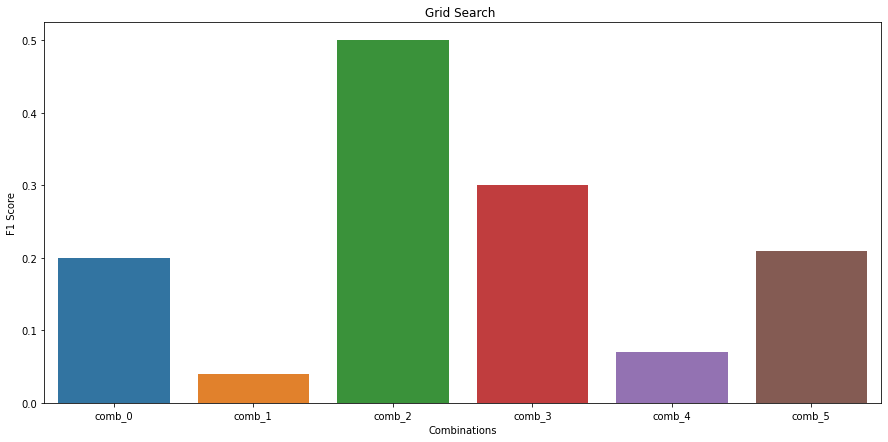

In [45]:


score_list=[0.2, 0.04, 0.5, 0.3, 0.07, 0.21]
plt.figure(figsize=(15, 7))
sns.barplot(["comb_"+str(v) for v in range(len(score_list))], score_list)
plt.title("Grid Search ")
plt.xlabel("Combinations")
plt.ylabel("F1 Score")

In [49]:
all_combinations[score_list.index(max(score_list))]

(40, 15, 0.4, 200)